### Data exploration and viz of Find it Fix It requests to the City of Seattle (from a FOI request)

In [27]:
#getting and working with data
import pandas as pd
import numpy as np
import math
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':30,
                              'axes.titlesize':30,
                              'axes.labelsize':30})
#sns.set_context("poster")
#sns.set_style("dark")
#sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [28]:
#path for FIFI cleaned and preprocessed data frame
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/zip_filtered_full_data.pkl'

In [29]:
#read in pkl file containing 
data = pd.read_pickle(path)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)

print('Original data shape:\n', data.shape, '\n')
print('Original data columns:\n', data.columns.values, '\n')

Original data shape:
 (248815, 39) 

Original data columns:
 ['Service_Request_Number' 'Created_Date' 'Location' 'Location_Details'
 'Description' 'License_Number' 'State' 'Vehicle_Make' 'Vehicle_Color'
 'Time_parked' 'Photo' 'FIFI_category' 'Location_Details.1'
 'Property_damage?' 'Current_Issue' 'Type_of_animal'
 'On_private_property?' 'Graffiti_location' 'Location_and_Description'
 'Obscene/Racial/Hateful?' 'Street/Intersection' 'Where?' 'Type_of_item?'
 'Veg_location' 'Vegetation_Safety_Issue' 'Parking_Violation_Concerning'
 'License_Plate_Number' 'Location_details' '7_digit_number_on_pole'
 'Issue' 'date' 'year' 'month' 'day' 'day_of_week' 'hour' 'date_bin' 'zip'
 'neighborhood'] 



In [30]:
#only use data that has complete year
data = data[data['year'].isin([2014, 2015, 2016, 2017, 2018])]

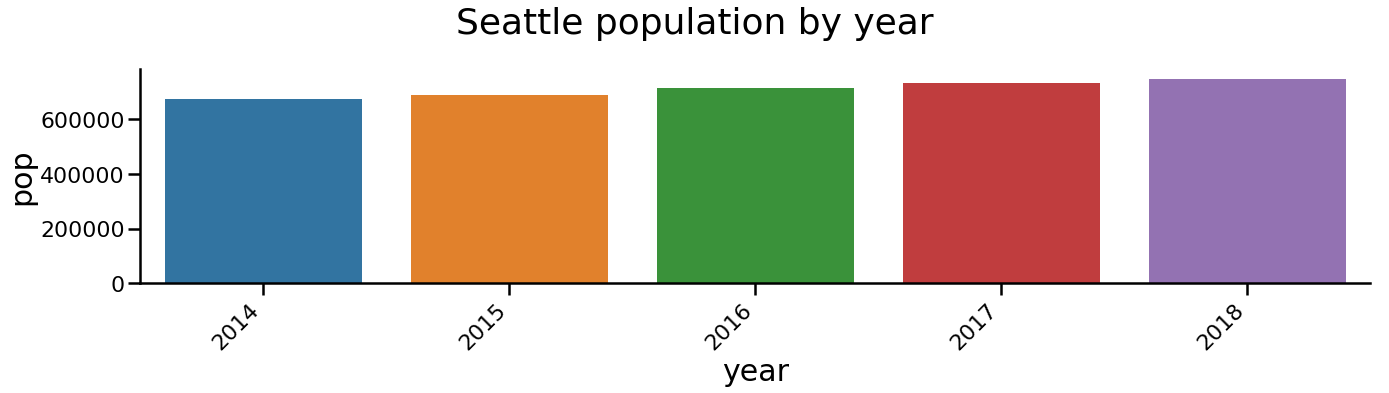

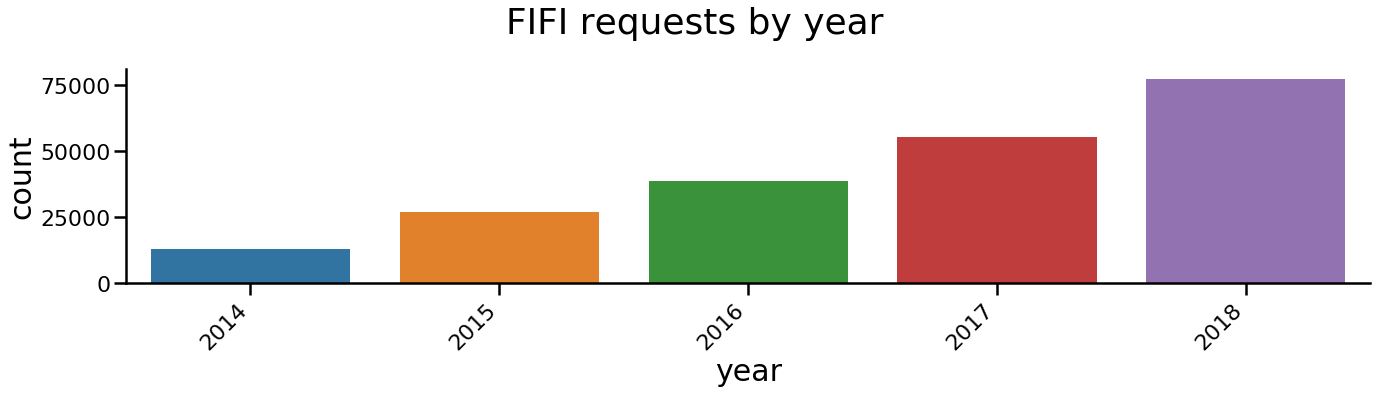

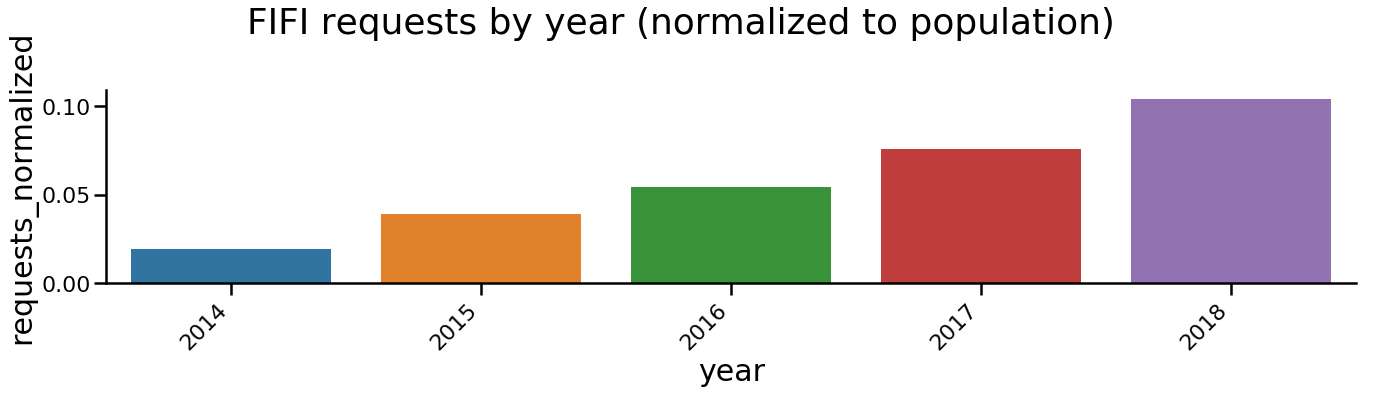

In [31]:
#viz FIFI request counts by year (and normalize for population growth)
seattle_pop = {'year': [2013, 2014, 2015, 2016, 2017, 2018, 2019], 'pop': [654224, 670925, 688156, 710510, 729601, 744955, 750000]}
seattle_pop_df = pd.DataFrame(data=seattle_pop, columns=['year', 'pop'])
year_count = data.groupby(['year'])['FIFI_category'].count().reset_index(name='count')
year_count_pop = pd.merge(seattle_pop_df, year_count, on='year')
year_count_pop['requests_normalized'] = year_count_pop['count'] / (year_count_pop['pop'])

#seattle population growth
g = sns.catplot(x='year', data=year_count_pop, y='pop', kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Seattle population by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)

g = sns.catplot(x='year', data=year_count_pop, y='count', kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)

g = sns.catplot(x='year', data=year_count_pop, y='requests_normalized', kind='bar', height=5, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year (normalized to population)', y=1.05)
plt.subplots_adjust(hspace = 1.5)

plt.show()

In [32]:
#read in excel file containing meta data on zip codes in seattle
path_demogs = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/neighborhood_demogs.xlsx'

#read in pkl file containing 
data_demogs = pd.read_excel(path_demogs)
data_demogs = pd.DataFrame(data = data_demogs)

print('Original data shape:\n', data_demogs.shape, '\n')
print(data_demogs.info())
data_demogs.head()

Original data shape:
 (39, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
zip             39 non-null object
neighborhood    39 non-null object
pop             29 non-null float64
COLI            29 non-null float64
pop den         29 non-null float64
income          28 non-null float64
unemploy        28 non-null float64
dtypes: float64(5), object(2)
memory usage: 2.2+ KB
None


,zip,neighborhood,pop,COLI,pop den,income,unemploy
0,98028,Kenmore,22103.0,113.9,3903.0,NaN,NaN
1,98031,Kent,NaN,NaN,NaN,NaN,NaN
2,98057,Renton,NaN,NaN,NaN,NaN,NaN
3,98101,Dt/FirstH,12216.0,118.9,23528.0,65925.0,3.8
4,98102,Cap_Hill,24374.0,117.0,18802.0,80565.0,2.7


In [59]:
neighborhood_count = data.groupby(['neighborhood'])['FIFI_category'].count().reset_index(name='count')
#combine neighborhood_count with corresponding zip code meta data
neighborhood_count_demogs = pd.merge(neighborhood_count, data_demogs, on='neighborhood', sort=False)
print(neighborhood_count_demogs.shape)
neighborhood_count_demogs['requests_normalized'] =  neighborhood_count_demogs['count'] / neighborhood_count_demogs['pop']
neighborhood_count_demogs.tail()

(36, 8)


,neighborhood,count,zip,pop,COLI,pop den,income,unemploy,requests_normalized
31,Udist/LarHur,10897,98105,47181.0,127.0,11442.0,53773.0,7.5,0.230962
32,WA,33501,WA,NaN,NaN,NaN,NaN,NaN,NaN
33,Wedgewood,7575,98115,50978.0,116.8,7743.0,101065.0,3.1,0.148594
34,WestS_Alki,3540,98116,25595.0,117.4,8657.0,90927.0,3.3,0.138308
35,Westlake,7024,98109,26277.0,117.2,13143.0,94602.0,3.3,0.267306


In [62]:
#create list of FIFI cats ordered by request count to use for ordering of x axis on graphs
cat_order = data['FIFI_category'].value_counts().index.values

#create list of neighborhoods ordered by request count to use for ordering of x axis on graphs
neigh_order = data['neighborhood'].value_counts().index.values

#create list of neighborhoods ordered by request count to use for ordering of x axis on graphs
neigh_pop_order = neighborhood_count_demogs.sort_values('pop', ascending=False)['neighborhood'].values

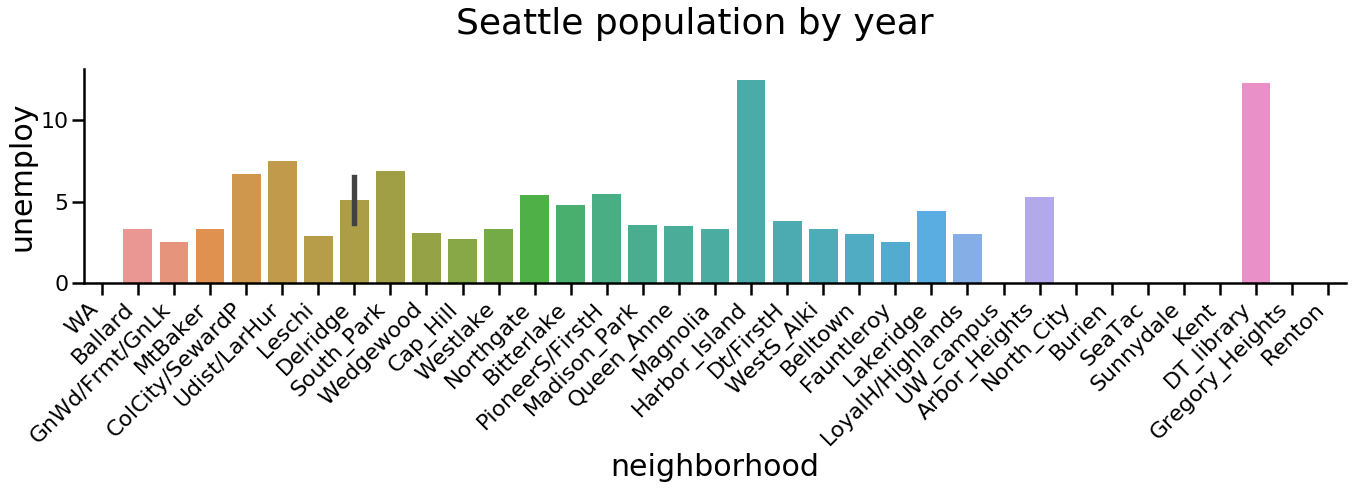

In [68]:
#seattle population growth
g = sns.catplot(x='neighborhood', data=neighborhood_count_demogs, y='unemploy', kind='bar', height=5, aspect=4, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Seattle population by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)

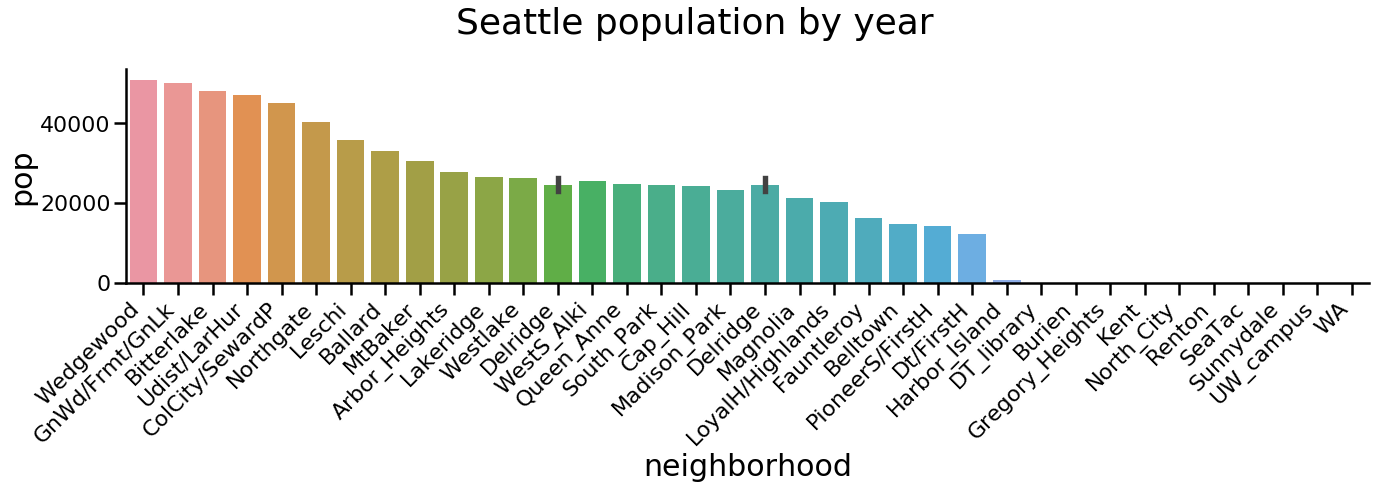

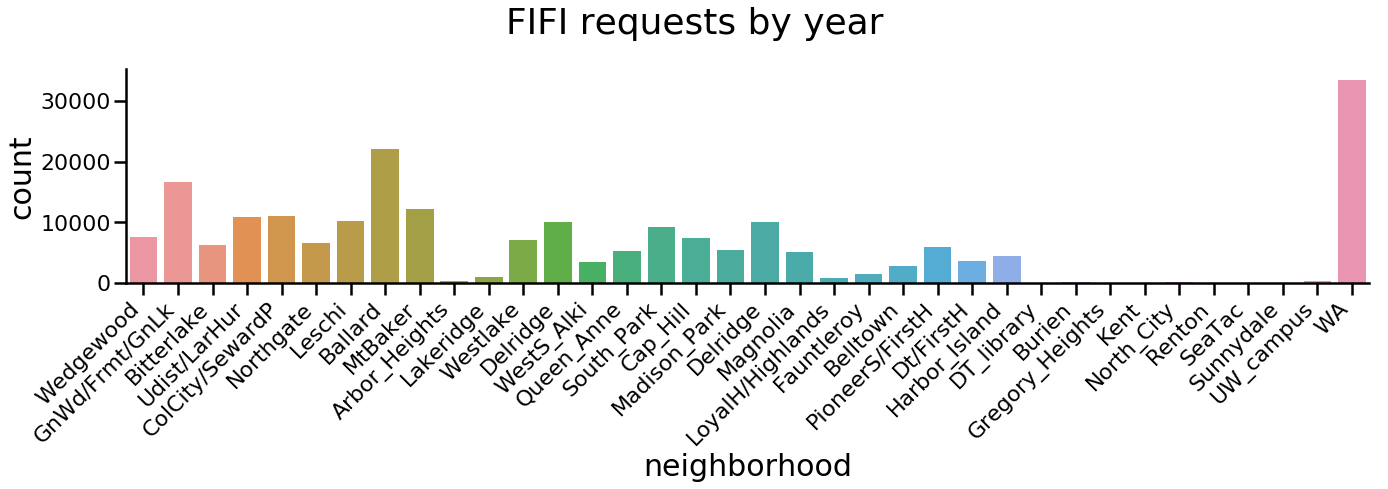

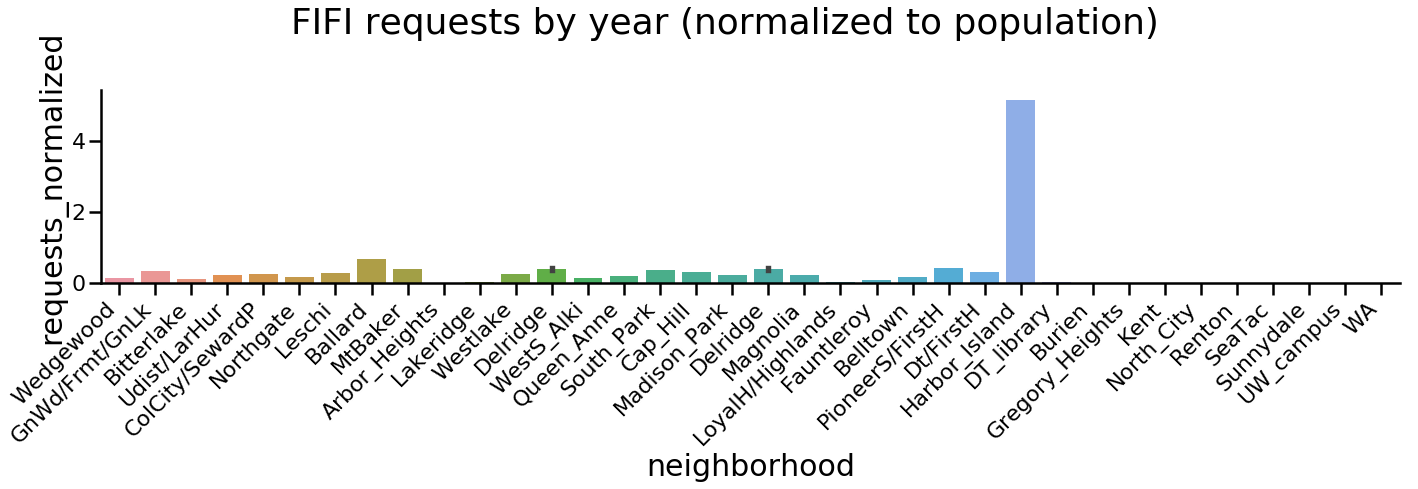

In [63]:
#seattle population growth
g = sns.catplot(x='neighborhood', data=neighborhood_count_demogs, y='pop', kind='bar', height=5, aspect=4, order=neigh_pop_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Seattle population by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)

g = sns.catplot(x='neighborhood', data=neighborhood_count_demogs, y='count', kind='bar', height=5, aspect=4, order=neigh_pop_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)

g = sns.catplot(x='neighborhood', data=neighborhood_count_demogs, y='requests_normalized', kind='bar', height=5, aspect=4, order=neigh_pop_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year (normalized to population)', y=1.05)
plt.subplots_adjust(hspace = 1.5)

plt.show()

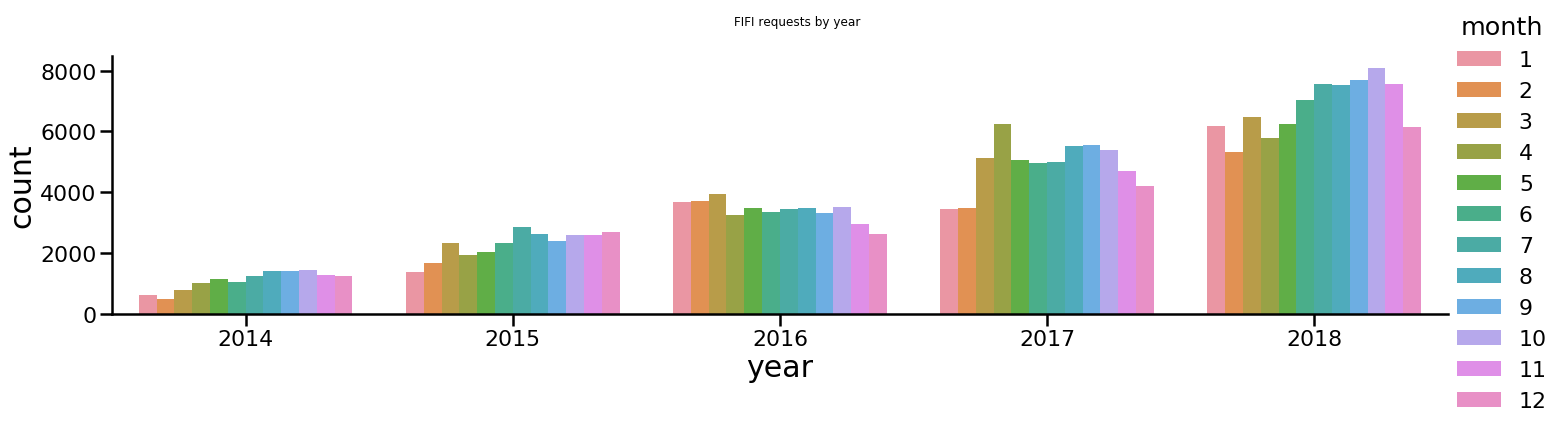

In [8]:
#viz FIFI requests across time
g = sns.catplot(x='year', data=data, kind='count', ci=68, height=5, aspect=4, hue='month')

#g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)
plt.show()


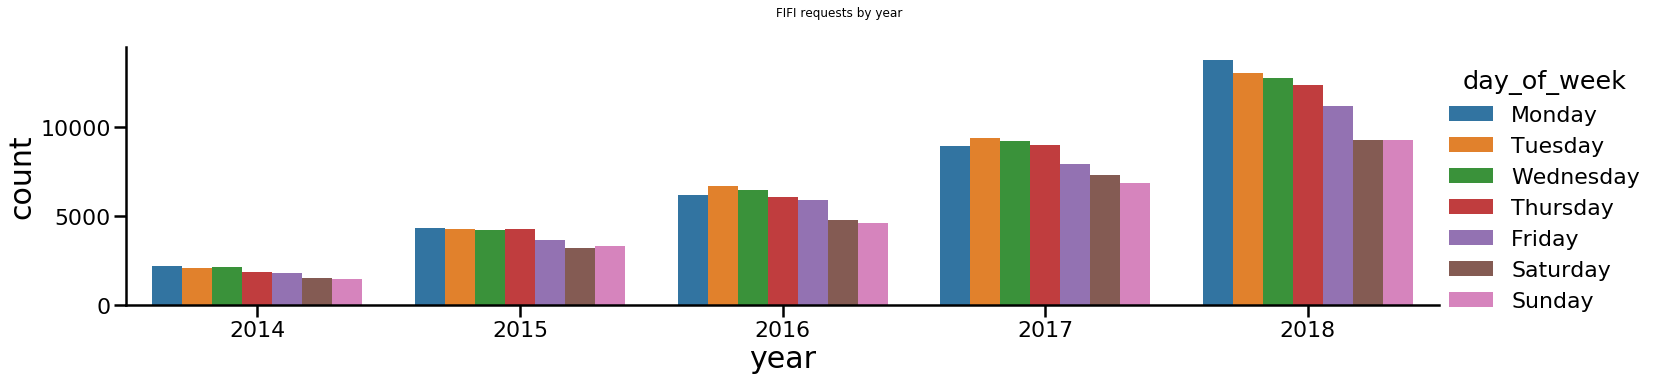

In [9]:
#viz FIFI requests across time
g = sns.catplot(x='year', data=data, kind='count', ci=68, height=5, aspect=4, hue='day_of_week')

#g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year', y=1.05)
plt.subplots_adjust(hspace = 1.5)
plt.show()


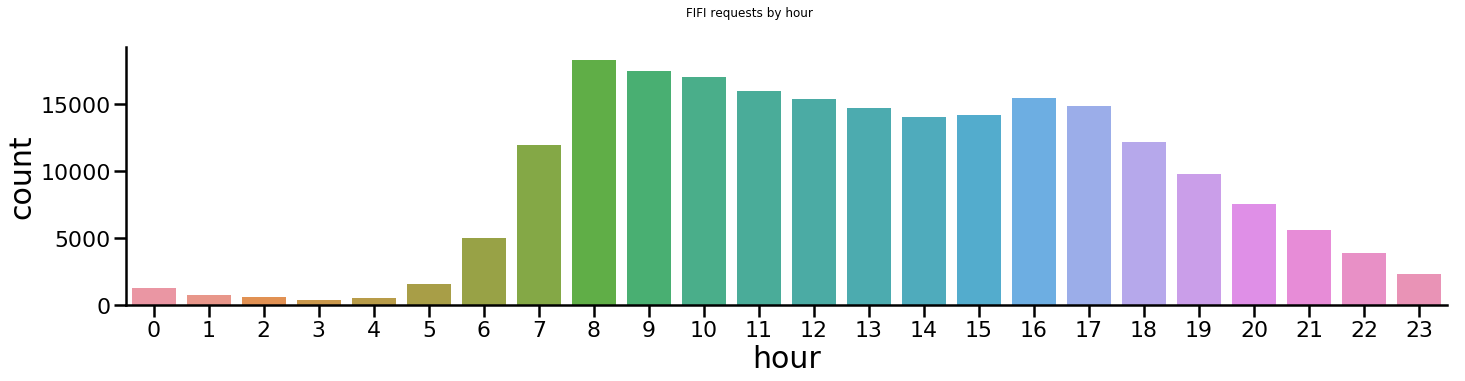

In [10]:
#viz FIFI requests across time
g = sns.catplot(x='hour', data=data, kind='count', ci=68, height=5, aspect=4)

#g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by hour', y=1.05)
plt.subplots_adjust(hspace = 1.5)
plt.show()

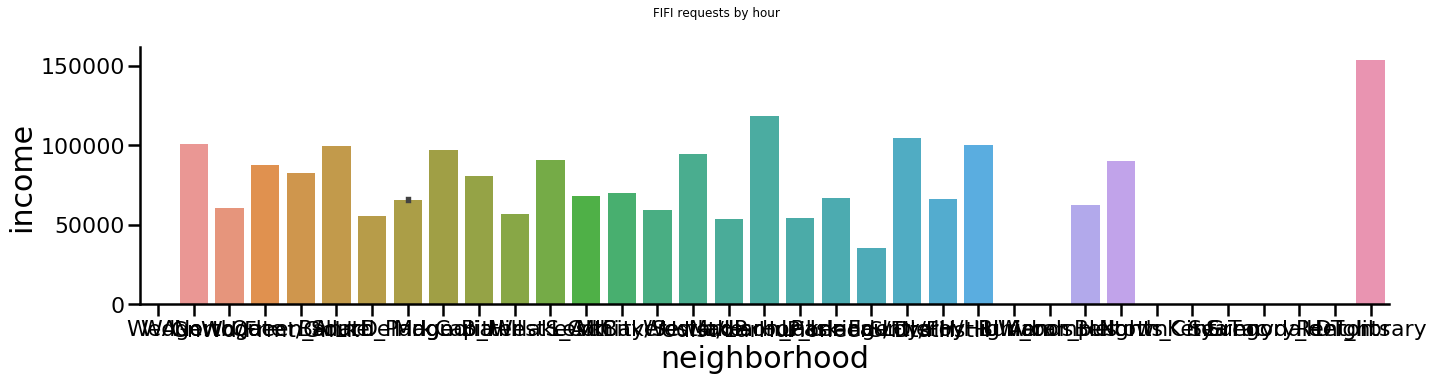

In [19]:
#viz FIFI requests across time
g = sns.catplot(x='neighborhood', y='income', data=data, kind='bar', ci=68, height=5, aspect=4)

#g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by hour', y=1.05)
plt.subplots_adjust(hspace = 1.5)
plt.show()

In [18]:
data.head()

,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,date_bin,zip_x,neighborhood,zip_y,pop,COLI,pop den,income,unemploy
301,14-00000081,2014-01-01 19:14:16,"4801 26TH AVE SW, SEATTLE, WA","4734 26th Ave SW, Seattle; XY: 1262162.3475353...","Abandoned car, left by people that seem to hav...",8BR445,SD,Mercedes-benz,White,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2014,1,1,Wednesday,19,"(1.387972961050282e+18, 1.3929650164605386e+18]",WA,WA,WA,NaN,NaN,NaN,NaN,NaN
302,14-00000108,2014-01-02 08:07:42,"4515 8TH AVE NW, SEATTLE, WA","4500-4598 8th Ave NW, Seattle; XY: 1262732.392...","Blue van on 8th ave nw, east side of street be...",Aca2207 blue van,WA,Gmc,Blue,Over 3 Days,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02,2014,1,2,Thursday,8,"(1.387972961050282e+18, 1.3929650164605386e+18]",WA,WA,WA,NaN,NaN,NaN,NaN,NaN
303,14-00000318,2014-01-02 13:50:35,"1416 E THOMAS ST, SEATTLE, WA","1410 E John St, Seattle; XY: 1275383.649071390...",Honda Civic,080-xxk,WA,Honda,Red,Over 3 Days,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02,2014,1,2,Thursday,13,"(1.387972961050282e+18, 1.3929650164605386e+18]",WA,WA,WA,NaN,NaN,NaN,NaN,NaN
304,14-00000454,2014-01-03 08:53:48,"3721 EASTERN AVE N, SEATTLE, WA","2501 N Northlake Way, Seattle; XY: 1271798.906...",OLD motor home has been parked on Northlake Av...,AKV4463,WA,Gmc,Green,Over 1 Month,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-03,2014,1,3,Friday,8,"(1.387972961050282e+18, 1.3929650164605386e+18]",WA,WA,WA,NaN,NaN,NaN,NaN,NaN
305,14-00000545,2014-01-03 11:06:57,"2266 NE 63RD ST, SEATTLE, WA","6307 23rd Ave NE, Seattle; XY: 1278323.2393751...",Expired tabs Parked over a week,B88266D,WA,Volkswagen,Silver,Over 1 Week,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-03,2014,1,3,Friday,11,"(1.387972961050282e+18, 1.3929650164605386e+18]",WA,WA,WA,NaN,NaN,NaN,NaN,NaN


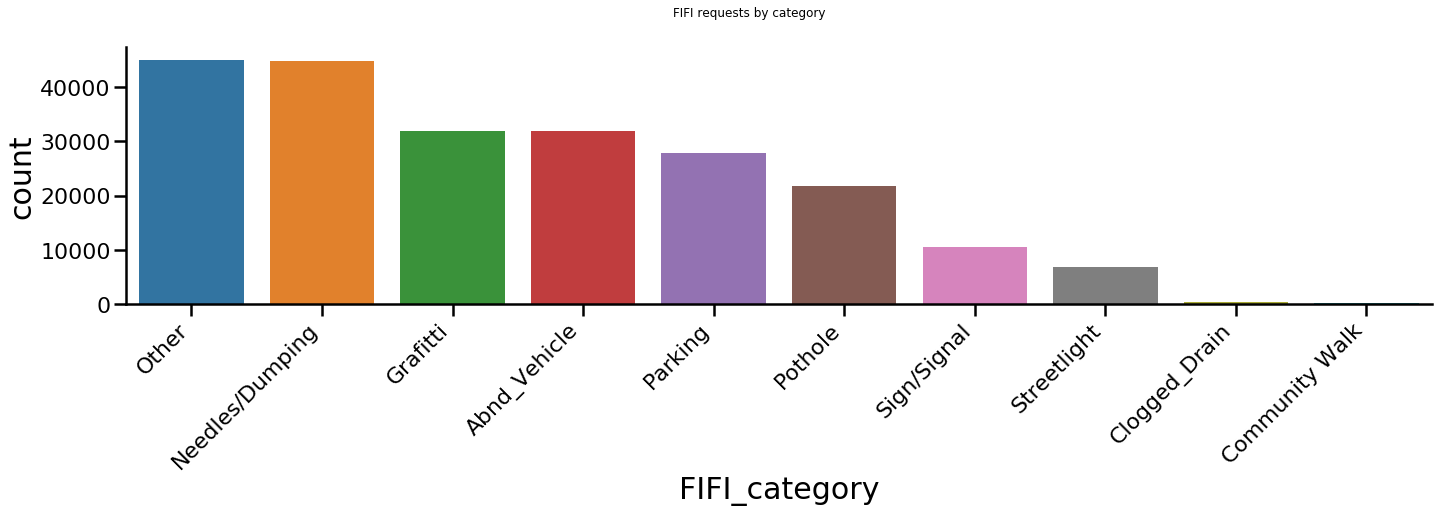

In [12]:
#counts across categories
g = sns.catplot(x='FIFI_category', data=data, kind='count', ci=68, height=5, aspect=4, \
                sharex=False, order=cat_order)

g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by category', y=1.05)
plt.subplots_adjust(hspace = 1.5)
plt.show()

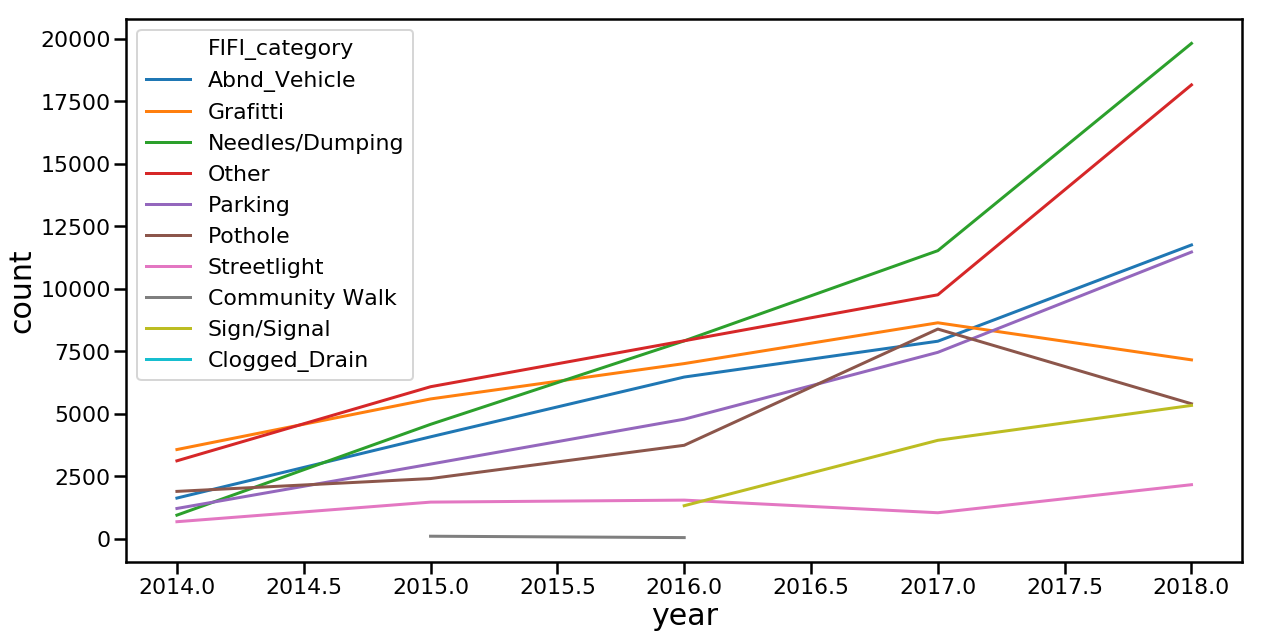

In [13]:
year_cat_count = data.groupby(['year', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

plt.figure(figsize=(20,10))
sns.lineplot(x='year', y='count', data=year_cat_count, hue='FIFI_category')
plt.show()

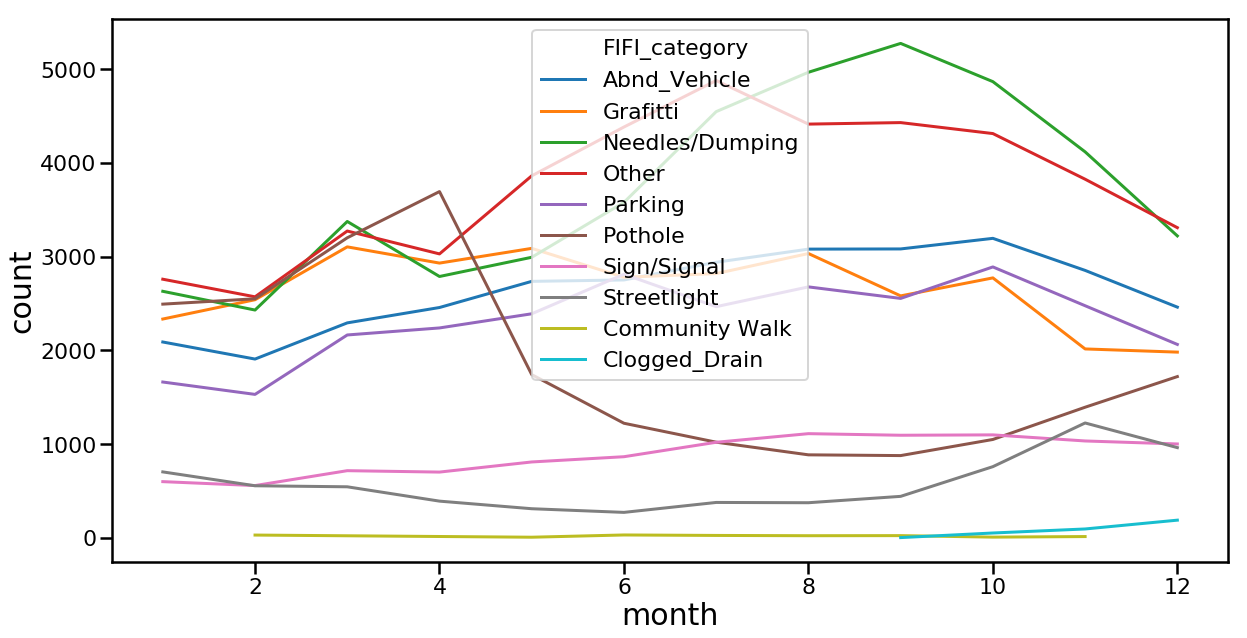

In [14]:
month_cat_count = data.groupby(['month', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

plt.figure(figsize=(20,10))
sns.lineplot(x='month', y='count', data=month_cat_count, hue='FIFI_category')
plt.show()

Text(0.5,1.05,'FIFI requests by date and neighborhood')

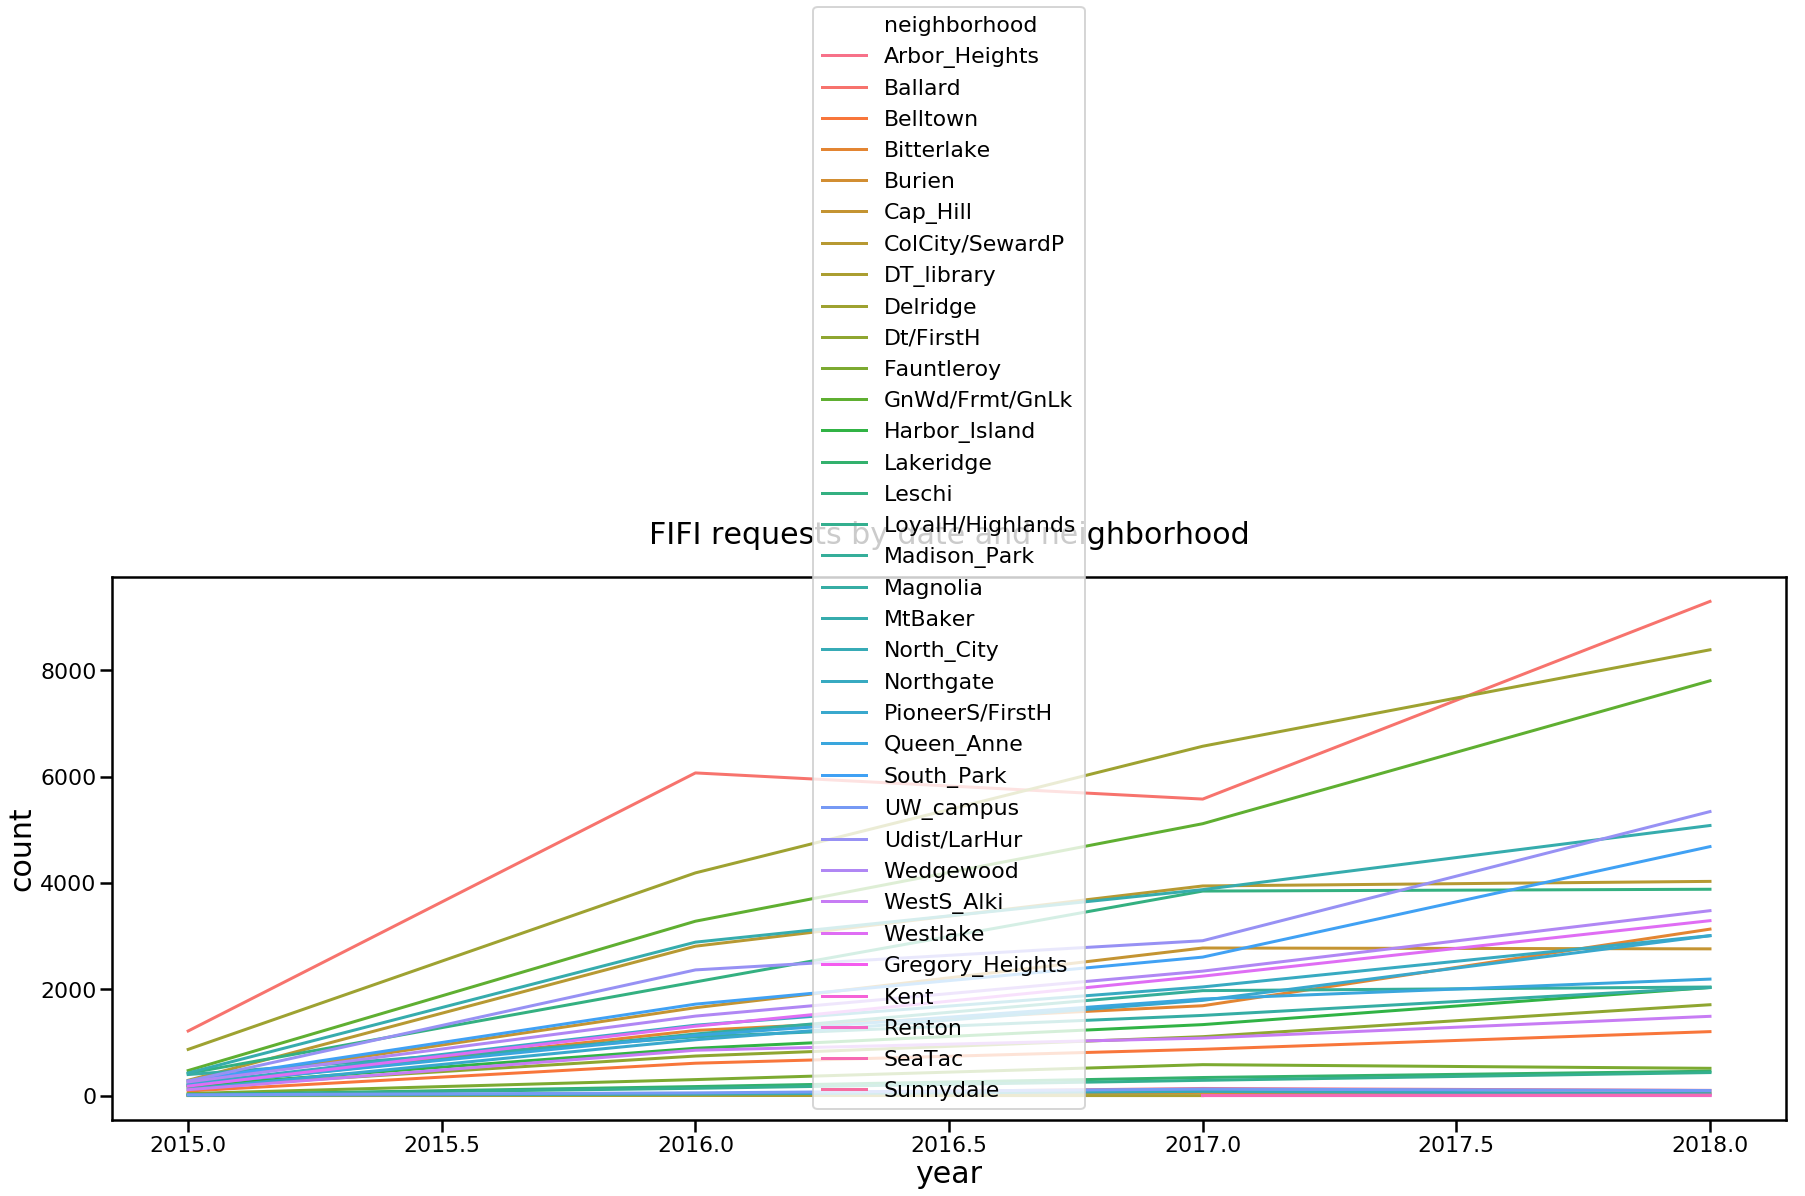

In [15]:
#create and viz number of FIFI requests by date and neighborhood
date_neigh_count = data[data['neighborhood'] != 'WA'].groupby(['year', 'neighborhood'])['FIFI_category'].count().reset_index(name='count')

plt.figure(figsize=(30,10))
sns.lineplot(x='year', y='count', data=date_neigh_count, ci=68, hue='neighborhood')

plt.title('FIFI requests by date and neighborhood', y=1.05)


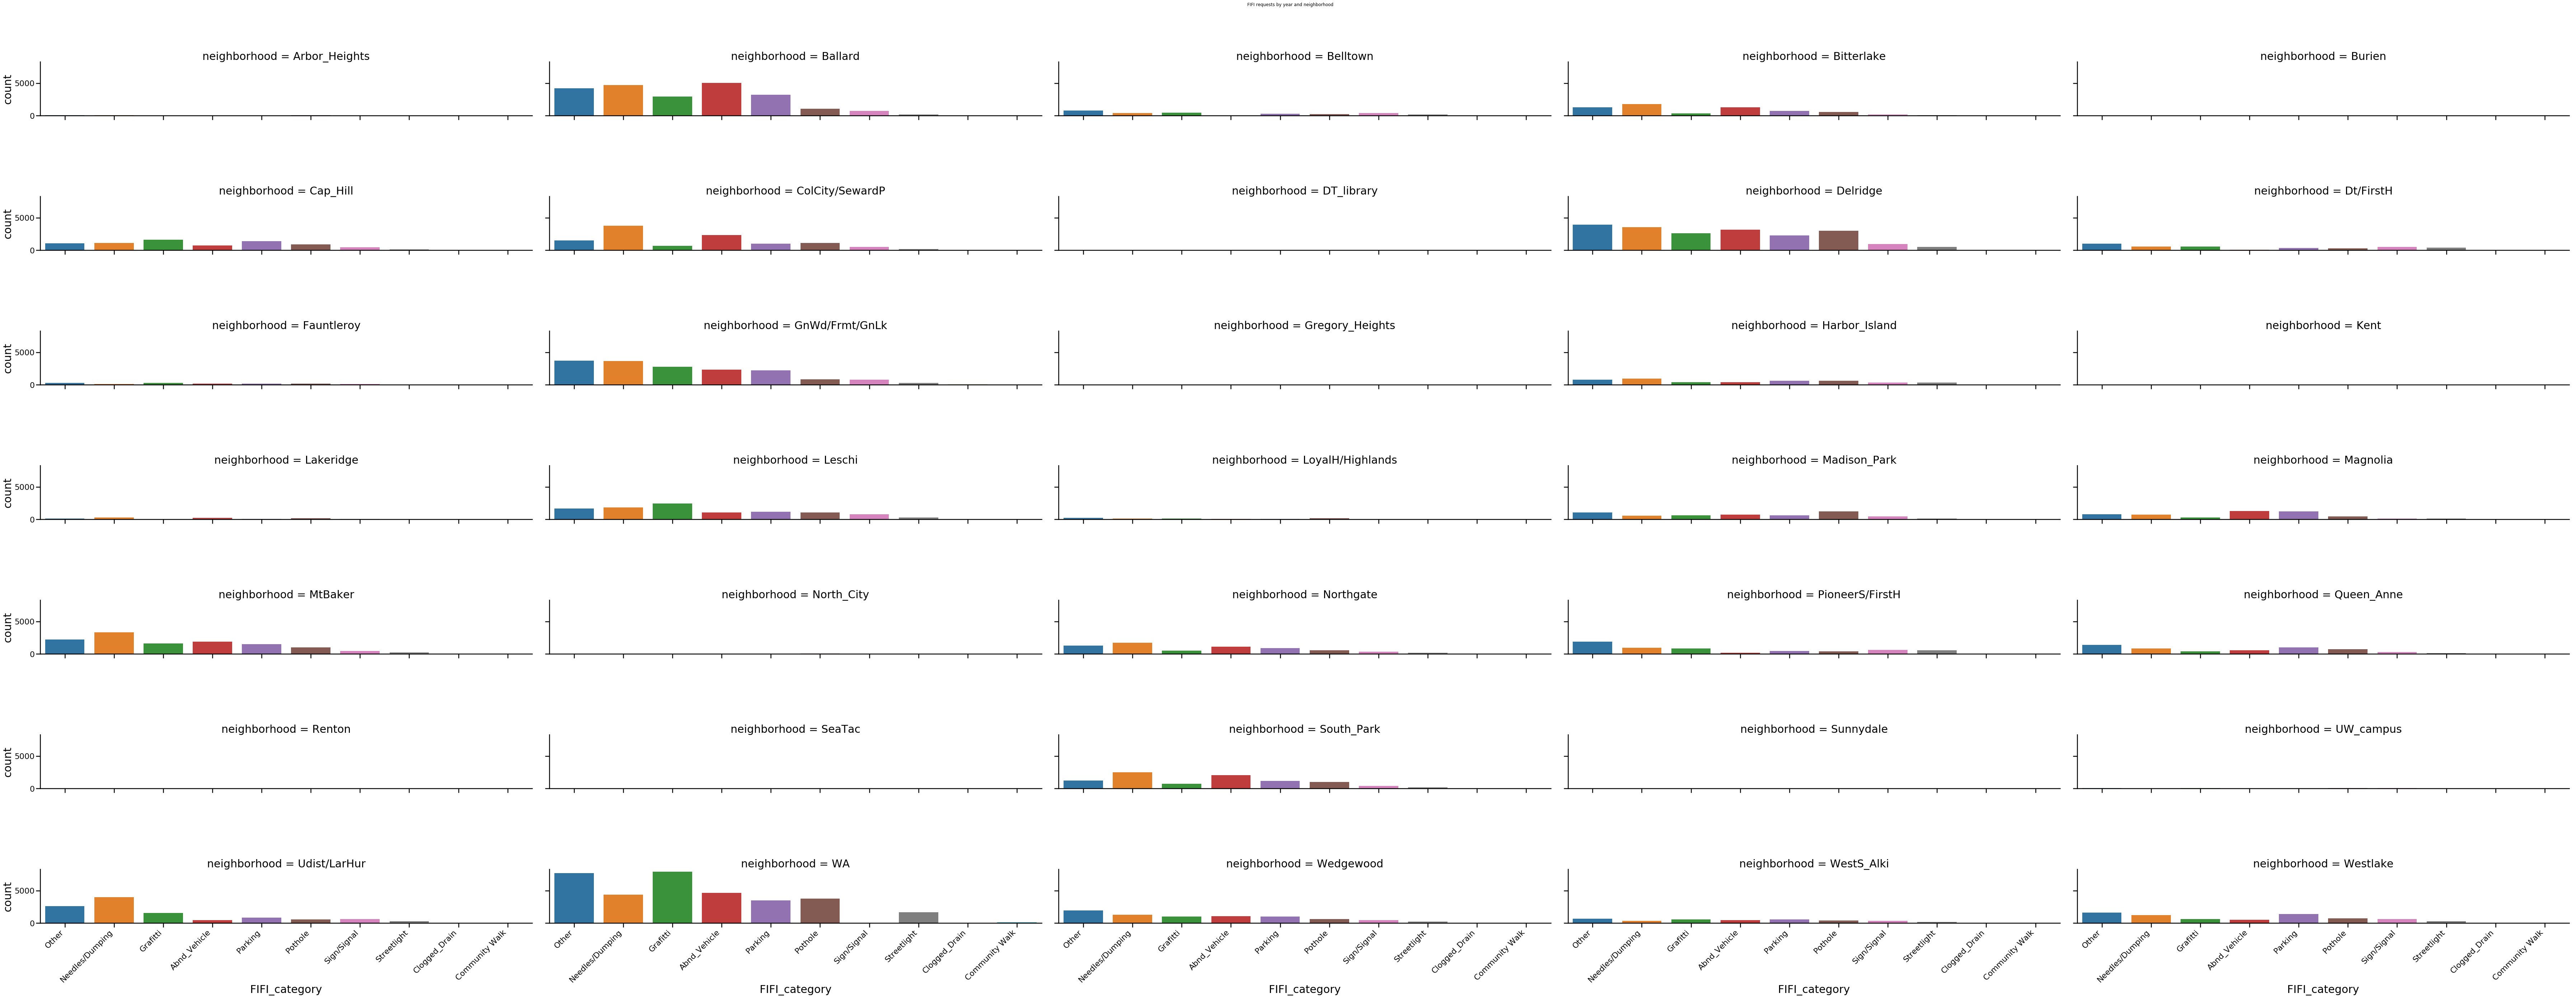

In [16]:
#create and viz number of FIFI requests by neighborhood and category
cat_neigh_count = data.groupby(['neighborhood', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

g = sns.catplot(x='FIFI_category', data=cat_neigh_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='neighborhood', col_wrap=5, sharey=True, order=cat_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year and neighborhood', y=1.05)
plt.subplots_adjust(hspace = 1.5)

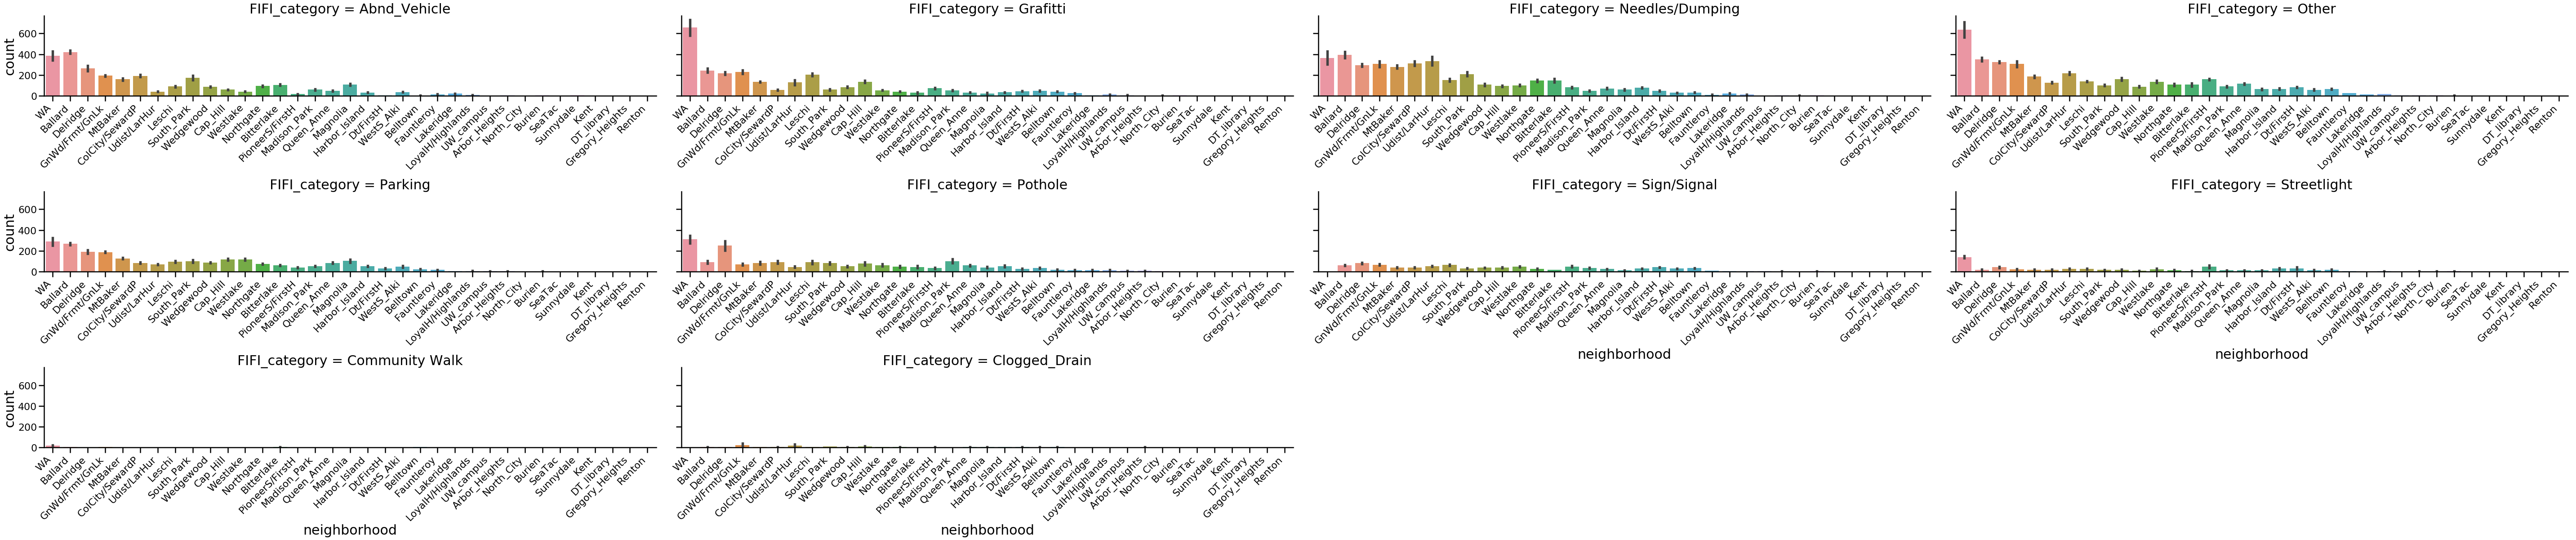

In [17]:
#create and viz number of FIFI requests by year, neighborhood, and category
year_neigh_cat_count = data.groupby(['month', 'neighborhood', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

g = sns.catplot(x='neighborhood', data=year_neigh_cat_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='FIFI_category', col_wrap=4, sharey=True, sharex=False, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

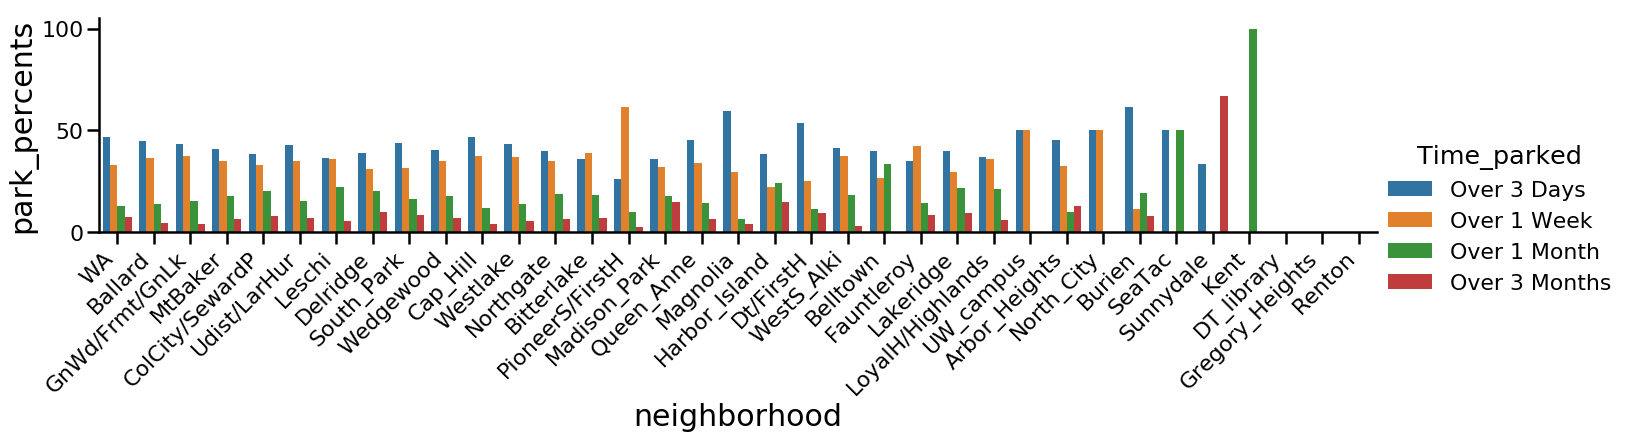

In [155]:
#viz the percentage of FIFI request for each time segment within the 'Abnd_Vehicle' category by neighborhood
data_vehicle = data[data['FIFI_category'] == 'Abnd_Vehicle']

cars_zip_count = data_vehicle.groupby('neighborhood')['Time_parked'].count().reset_index(name='Total_count')
cars_zip_park_count = data_vehicle.groupby('neighborhood')['Time_parked'].value_counts().reset_index(name='Time_count')

for neighborhood in data_vehicle['neighborhood'].unique():
    percents = cars_zip_park_count[cars_zip_park_count['neighborhood'] == neighborhood]['Time_count'].values / \
    cars_zip_count[cars_zip_count['neighborhood'] == neighborhood]['Total_count'].values * 100
    
    cars_zip_park_count.loc[cars_zip_park_count['neighborhood'] == neighborhood, 'park_percents'] = percents
    
    
g = sns.catplot(x='neighborhood', data=cars_zip_park_count, y='park_percents', kind='bar', hue='Time_parked', \
               ci=68, height=5, aspect=4, hue_order=['Over 3 Days', 'Over 1 Week', 'Over 1 Month', 'Over 3 Months'], order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

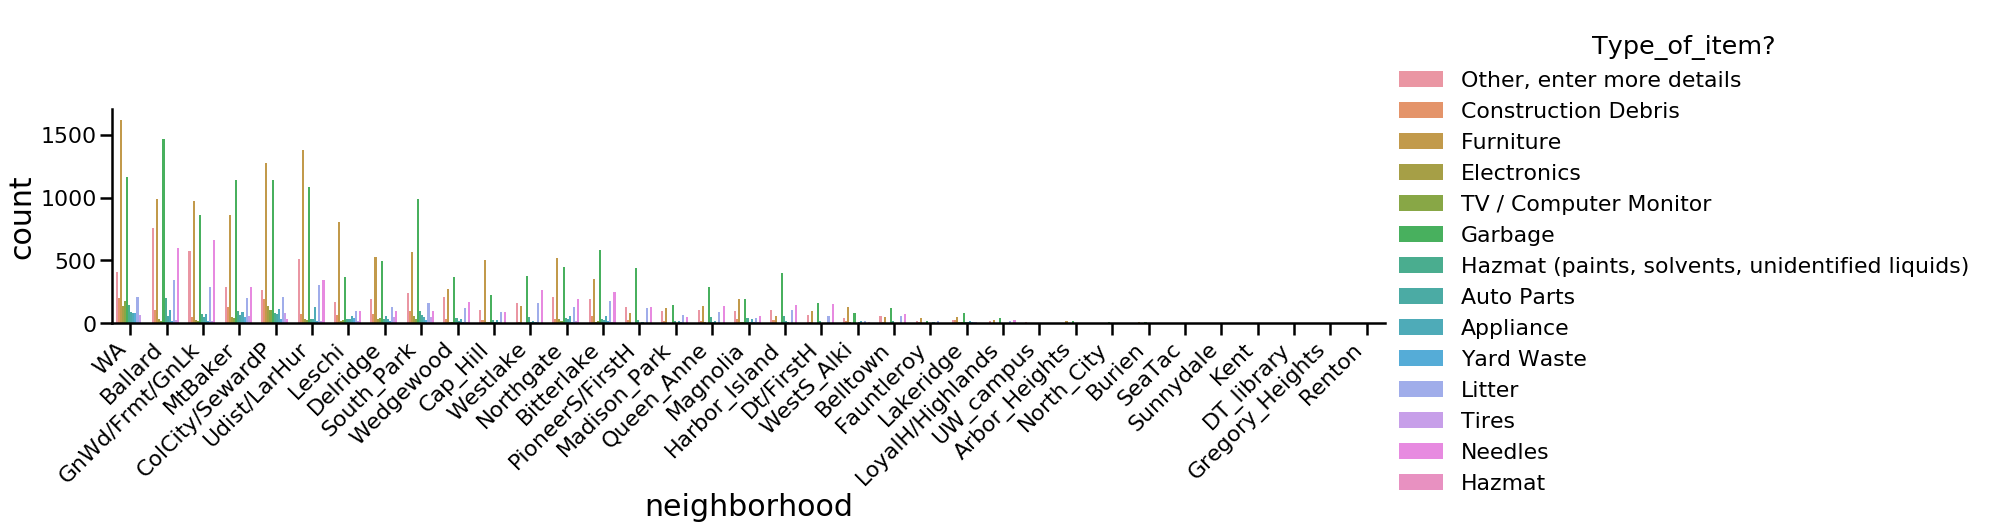

In [161]:
data_needles = data[data['FIFI_category'] == 'Needles/Dumping']

g = sns.catplot(x='neighborhood', data=data_needles, kind='count', hue='Type_of_item?', \
               ci=68, height=5, aspect=4, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

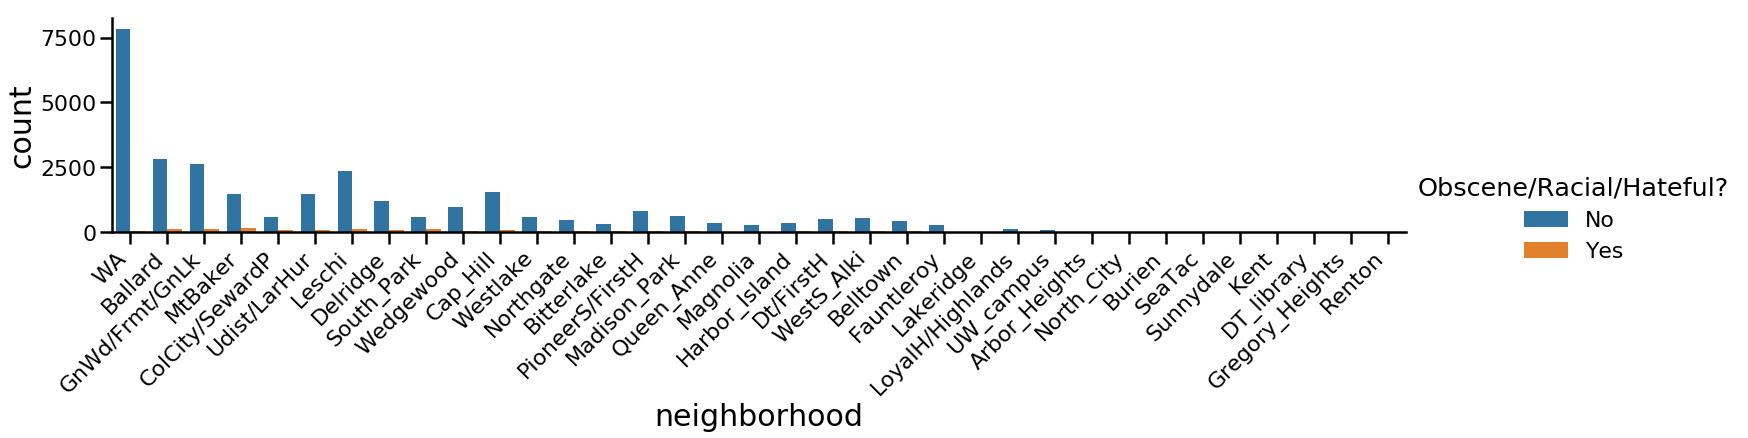

In [157]:
data_grafitti = data[data['FIFI_category'] == 'Grafitti']

g = sns.catplot(x='neighborhood', data=data_grafitti, kind='count', hue='Obscene/Racial/Hateful?', \
               ci=68, height=5, aspect=4, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

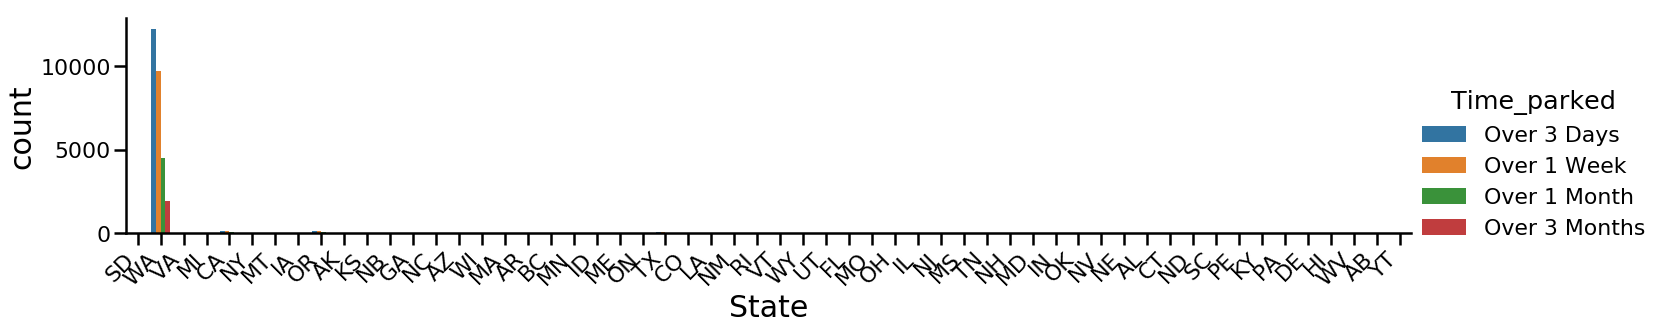

In [148]:
g = sns.catplot(x='State', data=data_vehicle, kind='count', hue='Time_parked', \
               ci=68, height=5, aspect=4, hue_order=['Over 3 Days', 'Over 1 Week', 'Over 1 Month', 'Over 3 Months'])
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

In [24]:
#select zips that have great than 999 entries
zip_counts = zip_filtered['zip'].value_counts()
zip_counts_1000 = zip_counts[zip_counts > 999].index.values
zip_filtered_1000 = zip_filtered[zip_filtered['zip'].isin(zip_counts_1000)]
print('Combined data final zips: ', zip_filtered['zip'].value_counts(), '\n')

#select FIFI categories that have great than 999 entries
cat_counts = combined_data_final['FIFI_category'].value_counts()
cat_counts_1000 = cat_counts[cat_counts > 999].index.values
combined_data_final = combined_data_final[combined_data_final['FIFI_category'].isin(cat_counts_1000)]
print('Combined data final FIFI categories: ', combined_data_final['FIFI_category'].value_counts(), '\n') 

['FacetGrid',
 'JointGrid',
 'PairGrid',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_orig_rc_params',
 'algorithms',
 'axes_style',
 'axisgrid',
 'barplot',
 'blend_palette',
 'boxenplot',
 'boxplot',
 'categorical',
 'catplot',
 'choose_colorbrewer_palette',
 'choose_cubehelix_palette',
 'choose_dark_palette',
 'choose_diverging_palette',
 'choose_light_palette',
 'clustermap',
 'cm',
 'color_palette',
 'colors',
 'countplot',
 'crayon_palette',
 'crayons',
 'cubehelix_palette',
 'dark_palette',
 'desaturate',
 'despine',
 'distplot',
 'distributions',
 'diverging_palette',
 'dogplot',
 'external',
 'factorplot',
 'get_dataset_names',
 'heatmap',
 'hls_palette',
 'husl_palette',
 'jointplot',
 'kdeplot',
 'light_palette',
 'lineplot',
 'lmplot',
 'load_dataset',
 'lvplot',
 'matrix',
 'miscplot',
 'mpl',
 'mpl_palette',
 'pairplot',
 'palettes',
 'palplot',
 'plotting_context',
 'poin